# Artificial Visual Imagination 
## Text to Image with BigGAN + CLIP + CMA-ES

---

BIGCLIP [j.mp/bigclip](https://j.mp/bigclip) by Eyal Gruss [@eyaler](https://twitter.com/eyaler) [eyalgruss.com](https://eyalgruss.com)


Modified to run on nautilus.optiputer.net by robert.twomey@gmail.com

# 1. Generating from Saved Vector

from https://github.com/huggingface/pytorch-pretrained-BigGAN#usage

In [1]:
# !pip install perlin-noise

In [2]:
from IPython.display import HTML, clear_output
from PIL import Image
from IPython.display import Image as JupImage
import numpy as np
import nltk
from scipy.stats import truncnorm

# from biggan
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, convert_to_images) #, display_in_terminal)
import logging
logging.basicConfig(level=logging.WARNING)

# do we need wordnet?
nltk.download('wordnet')

# load biggan
model = BigGAN.from_pretrained('biggan-deep-512')
print("loaded bigGAN")

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


loaded bigGAN


In [3]:
# def save(out, name):
#     with torch.no_grad():
#         out = out.cpu().numpy()
#     img = convert_to_images(out)[0]
#     imageio.imwrite(name, np.asarray(img))

In [4]:
# from IPython.display import Image
# display(Image("output_0.png"))

Generate from a set of vectors

# 2. Latent+Class Interpolation

In [5]:
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
import os
import glob

# from
# https://discuss.pytorch.org/t/help-regarding-slerp-function-for-generative-model-sampling/32475/4

# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return np.asarray(vectors)

Interpolate between a set of vectors:

In [6]:
# np.random.RandomState(1)
# np.random.seed(1)
# torch.manual_seed(1)

# Prepare a input
truncation = 1.0
resultsbase = '/home/jovyan/work/results_wright/'
workbase = '/home/jovyan/work/'
interpbase = '/home/jovyan/work/interpolation'

# sculptures: 

# class_filenames = [
# "work/visual-imagination/CLIP/class_sculpture television buddha.txt",
# "work/visual-imagination/CLIP/class_a buddha sculpture with television in the grass.txt",
# "work/visual-imagination/CLIP/class_television buddha sculpture with grass.txt",
# "work/visual-imagination/CLIP/class_old television in grass with buddha sculpture by pacific ocean.txt",
# "work/visual-imagination/CLIP/class_old television in long grass with buddha sculpture by pacific ocean.txt"
# ]

# noise_filenames = [
# "work/visual-imagination/CLIP/noise_sculpture television buddha.txt",
# "work/visual-imagination/CLIP/noise_a buddha sculpture with television in the grass.txt",
# "work/visual-imagination/CLIP/noise_television buddha sculpture with grass.txt",
# "work/visual-imagination/CLIP/noise_old television in grass with buddha sculpture by pacific ocean.txt",
# "work/visual-imagination/CLIP/noise_old television in long grass with buddha sculpture by pacific ocean.txt"
# ]

# prompts = [
#     'a photo of wild tarragon',
#     'a drawing of wild tarragon, a tasteless plant',
#     'a painting of farm hands, a kind of laborer',
#     'a painting of a farmer’s hands',
#     'a self-portrait of Artemisia Gentileschi, artist',
#     'artemisia Gentileschi is a dragon',
#     'a painting of Artemisia Gentileschi as a dragon',
#     'a photo of the dragon Artemisia Gentileschi',
#     'a portrait of artist as dragon',
#     'a drawing of a dragon',
#     'a painting of uprooted rhizome as a dragon',
#     'a sketch of a rhizome, uprooted',
#     'an image of a plant rising',
#     'a drawing of plant roots and mycorrhizal fungi',
#     'an image of growing wiser',
#     'a painting of wise plants',
#     'a drawing of plant wisdom',
#     'a photo of a plant hiding',
#     'a drawing of hiding from elders',
#     'a painting of Susanna and the Elders',
#     'an image of creeps',
#     'a painting of gazing creeps',
#     'a painting of groping creeps',
#     'a painting of invasive elders',
#     'a photo of perverse hope',
#     'a painting of your hatred',
#     'a drawing of killing a mosquito',
#     'a painting of a mosquito, a kind of corpse',
#     'a drawing of malaria',
#     'a sketch of salted fields',
#     'a photo of dancers',
#     'a painting of dancers in a field',
#     'an image of your spit',
#     'a photo of standing too close',
#     'a painting of someone standing too close',
#     'a drawing of an oak sapling',
#     'a painting of an oak in an empty field',
#     'a photo of growing',
#     'an image of growing wilder',
#     'a painting of growing stronger',
#     'a photo of a hand holding high',
#     'a painting of a hand holding the head of Holofernes',
#     'a painting of the head of Holofernes',
#     'a drawing of a head, blood-rooted',
#     'an image of a bloody root',
#     'a painting of autumn gold',
#     'a photo of a golden gown',
#     'an image of a mouth tasting',
#     'a sketch of a mouth',
#     'a drawing of taste',
#     'a painting of the taste of nothing',
#     'a photograph of being invisible',
#     'a drawing of your renown',
#     'a painting of a renowned artist',
#     'a portrait of the artist',
#     'a self-portrait of Artemisia Gentileschi as tarragon'
# ]

# prompts = [
#     'a picture of the interior of a bedroom',
#     'a drawing of the interior of a bedroom', 
#     'a photo of the interior of a bedroom', 
#     'a photo of a bathroom',
#     'a photo of a kitchen', 
#     'a photo of a front door'
# ]

# prompts = [
#     'a photo of a front door',
#     'a picture of the mud room',
#     'a photo of the kitchen', 
#     'a photo of the livingroom with television', 
#     'a photo of a couch and a television', 
#     'a photo of a family on a couch', 
#     'a picture a kitchen', 
#     'a photo of food on the kitchen counter',
#     'a photo of a pie in the oven',
#     'a photo of a bathroom',
#     'a photo of the interior of a bathroom',
#     'a photo of a person in a shower', 
#     'a photo of person brushing their teeth',
#     'a picture of the interior of a bedroom',
#     'a picture of a person sleeping in a bed', 
#     'a photo of a sunrise through a window'
# ]

# prompts = [
#     "sunrise through a window",
#     "a cat in the refrigerator"
# ]

prompts = [
    "over my head, I see the bronze butterfly",
    "asleep on the black trunk",
    "blowing like a leaf in green shadow",   
    "down the ravine behind the empty house",   
    "the cowbells follow one another",   
    "into the distances of the afternoon",   
    "to my right",
    "in a field of sunlight between two pines",   
    "the droppings of last year’s horses",   
    "blaze up into golden stones",
    "I lean back, as the evening darkens and comes on",
    "a chicken hawk floats over, looking for home",
    "I have wasted my life"
]

safe_prompts = [prompt.replace(' ', '_') for prompt in prompts]

# print(safe_prompts)

def get_class_file(path, prompt):
    result = glob.glob(path+'%s_*_class.txt'%prompt)
    return(result)

def get_noise_file(path, prompt):
    result = glob.glob(path+'%s_*_noise.txt'%prompt)
    return(result)

!mkdir -p $interpbase

# print(get_class_file(workbase, safe_prompts[0]))
# print(get_noise_file(workbase, safe_prompts[0]))

In [7]:
class_filenames = [get_class_file(resultsbase, prompt)[0] for prompt in safe_prompts]
noise_filenames = [get_noise_file(resultsbase, prompt)[0] for prompt in safe_prompts]

# print(class_filenames, noise_filenames)

# Interpolate with Noise

In [ ]:
# # for perlin noise
# import matplotlib.pyplot as plt
# from perlin_noise import PerlinNoise

# noise = PerlinNoise(octaves=10, seed=1)
# xpix, ypix = noise_vector.shape[0], noise_vector.shape[1]

# pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]

# plt.imshow(pic, cmap='gray')
# plt.show()

In [ ]:
# import random
# import math
# from PIL import Image

# perm = list(range(256))
# random.shuffle(perm)
# perm += perm
# dirs = [(math.cos(a * 2.0 * math.pi / 256),
#          math.sin(a * 2.0 * math.pi / 256))
#          for a in range(256)]

# def noise(x, y, per):
#     def surflet(gridX, gridY):
#         distX, distY = abs(x-gridX), abs(y-gridY)
#         polyX = 1 - 6*distX**5 + 15*distX**4 - 10*distX**3
#         polyY = 1 - 6*distY**5 + 15*distY**4 - 10*distY**3
#         hashed = perm[perm[int(gridX)%per] + int(gridY)%per]
#         grad = (x-gridX)*dirs[hashed][0] + (y-gridY)*dirs[hashed][1]
#         return polyX * polyY * grad
#     intX, intY = int(x), int(y)
#     return (surflet(intX+0, intY+0) + surflet(intX+1, intY+0) +
#             surflet(intX+0, intY+1) + surflet(intX+1, intY+1))

# def fBm(x, y, per, octs):
#     val = 0
#     for o in range(octs):
#         val += 0.5**o * noise(x*2**o, y*2**o, per*2**o)
#     return val

# size, freq, octs, data = 256, 1/32.0, 5, []
# for y in range(size):
#     for x in range(size):
#         data.append(fBm(x*freq, y*freq, int(size*freq), octs))
# data = np.array(data).reshape(size, size)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# from https://github.com/pvigier/perlin-numpy/issues/1

def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    # Make the noise tileable
    gradients[-1,:] = gradients[0,:]
    gradients[:,-1] = gradients[:,0]
    # Same as before
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:  ,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:  ].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:  ,1:  ].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [20]:
perlin2d = generate_perlin_noise_2d((1024, 1024), (16, 16))

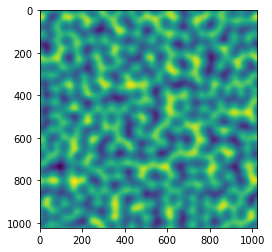

In [21]:
plt.imshow(perlin2d)

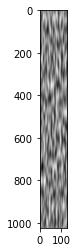

In [22]:
from skimage.transform import resize
img = resize(perlin2d, (1024, 128))
# # img = data
plt.imshow(img, cmap='gray')
# # plt.show()

In [ ]:
noisebase = "/home/jovyan/work/noise_interp"
!mkdir -p $noisebase

num_steps = 100
noise_noise_scale = 1.0#0.1
class_noise_scale = 0.0
count = 0

i=0
# files
class_inputs = [np.loadtxt(filename) for filename in class_filenames]
noise_inputs = [np.loadtxt(filename) for filename in noise_filenames]

# interpolate
noises = interpolate_points(noise_inputs[i], noise_inputs[(i+1)%len(class_inputs)], num_steps)
classes = interpolate_points(class_inputs[i], class_inputs[(i+1)%len(class_inputs)], num_steps)

# generate vectors
batch_size = 10
for j in range(0, num_steps, batch_size):
    noise_vector = noises[j:j+batch_size]
    noise_noise = np.random.uniform(size=noise_vector.shape)*noise_noise_scale
    noise_vector = noise_vector + noise_noise

    class_vector = classes[j:j+batch_size]
    class_noise = np.random.uniform(size=class_vector.shape)*class_noise_scale
    class_vector = class_vector + class_noise

    # expand dims
#     noise_vector = np.expand_dims(noise_vector, axis=0)
#     class_vector = np.expand_dims(class_vector, axis=0)

    # convert to tensors
    noise_vector = torch.tensor(noise_vector, dtype=torch.float32)
    class_vector = torch.tensor(class_vector, dtype=torch.float32)

    # If you have a GPU, put everything on cuda
    noise_vector = noise_vector.to('cuda')
    noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
    class_vector = class_vector.to('cuda')
    class_vector = class_vector.softmax(dim=-1)
    model.to('cuda')

    # Generate an image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation)

    # If you have a GPU put back on CPU
    output = output.to('cpu')

#     for k in range(output.shape[0]):
#         img = torch.unsqueeze(output[k], 0)
#         save_as_images(img, noisebase+"/output_%05d" % count)
#         # use convert_to_images instead
#         # see https://github.com/huggingface/pytorch-pretrained-BigGAN/blob/1e18aed2dff75db51428f13b940c38b923eb4a3d/pytorch_pretrained_biggan/utils.py#L36
#         count = count + 1
    imgs = convert_to_images(output)
    for img in imgs: 
        img.save(noisebase+"/output_%05d.png" % count)
        count = count + 1
        

Render as video (mp4) with ffmpeg

In [ ]:
# fps = 30

# out = 'domestic_class_noise%s_%s_%s.mp4'% (fps, noise_noise_scale, class_noise_scale)
# with open('list.txt','w') as f:
#   for i in range(count):
#     f.write('file %snoise_interp/output_%05d.png\n'%(workbase, i))
# !ffmpeg -loglevel quiet -r $fps -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r $fps $out -y
# # !echo ffmpeg -r $fps -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r $fps $out -y

# Notes


Based on SIREN+CLIP Colabs by: [@advadnoun](https://twitter.com/advadnoun), [@norod78](https://twitter.com/norod78)

Other CLIP notebooks: [OpenAI tutorial](https://colab.research.google.com/github/openai/clip/blob/master/Interacting_with_CLIP.ipynb), [SIREN by @advadnoun](https://colab.research.google.com/drive/1FoHdqoqKntliaQKnMoNs3yn5EALqWtvP), [SIREN by @norod78](https://colab.research.google.com/drive/1K1vfpTEvAmxW2rnhAaALRVyis8EiLOnD), [BigGAN by @advadnoun](https://colab.research.google.com/drive/1NCceX2mbiKOSlAd_o7IU7nA9UskKN5WR), [BigGAN by @eyaler](j.mp/bigclip), [BigGAN by @tg_bomze](https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Text2Image_v2.ipynb), [BigGAN using big-sleep library by @lucidrains](https://colab.research.google.com/drive/1MEWKbm-driRNF8PrU7ogS5o3se-ePyPb), [BigGAN story hallucinator by @bonkerfield](https://colab.research.google.com/drive/1jF8pyZ7uaNYbk9ZiVdxTOajkp8kbmkLK), [StyleGAN2-ADA Anime by @nagolinc](https://colab.research.google.com/github/nagolinc/notebooks/blob/main/TADNE_and_CLIP.ipynb) [v2](https://colab.research.google.com/github/nagolinc/notebooks/blob/main/CLIP_%2B_TADNE_(pytorch)_v2.ipynb)

Using the works:

https://github.com/openai/CLIP

https://tfhub.dev/deepmind/biggan-deep-512

https://github.com/huggingface/pytorch-pretrained-BigGAN

http://www.aiartonline.com/design-2019/eyal-gruss (WanderGAN)

For a curated list of more online generative tools see: [j.mp/generativetools](https://j.mp/generativetools)


# Leftovers

Ex2. Interpolating between two vectors:

In [ ]:
# np.random.RandomState(1)
# np.random.seed(1)
# torch.manual_seed(1)

# num_steps = 500

# # Prepare a input
# truncation = 1.0
# workbase = '/home/jovyan/'

# # sculptures: 


# # work/visual-imagination/CLIP/class_sculpture television buddha.txt
# # work/visual-imagination/CLIP/class_a buddha sculpture with television in the grass.txt
# # work/visual-imagination/CLIP/class_television buddha sculpture with grass.txt
# # work/visual-imagination/CLIP/class_old television in grass with buddha sculpture by pacific ocean.txt
# # work/visual-imagination/CLIP/class_old television in long grass with buddha sculpture by pacific ocean.txt


# noise1 = np.loadtxt(workbase+'work/output_20210222_195143/noise_00002.txt')
# class1 = np.loadtxt(workbase+'work/output_20210222_195143/class_00002.txt')

# noise2 = np.loadtxt(workbase+'work/output_20210222_195143/noise_00008.txt')
# class2 = np.loadtxt(workbase+'work/output_20210222_195143/class_00008.txt')

# # noise_vector = np.loadtxt(workbase+'work/visual-imagination/CLIP/noise_a room with good lighting.txt')
# # class_vector = np.loadtxt(workbase+'work/visual-imagination/CLIP/class_a room with good lighting.txt')

# # interpolate
# noises = interpolate_points(noise1, noise2, num_steps)
# classes = interpolate_points(class1, class2, num_steps)

# # expand dims (only necessary for single vector)

# for i in range(num_steps):
    
#     # expand dims
#     noise_vector = np.expand_dims(noises[i], axis=0)
#     class_vector = np.expand_dims(classes[i], axis=0)

#     # convert to tensors
#     noise_vector = torch.tensor(noise_vector, dtype=torch.float32)
#     class_vector = torch.tensor(class_vector, dtype=torch.float32)

#     print(noise_vector.shape, noise_vector.dtype, class_vector.shape, class_vector.dtype)

#     # If you have a GPU, put everything on cuda
#     noise_vector = noise_vector.to('cuda')
#     noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
#     class_vector = class_vector.to('cuda')
#     class_vector = class_vector.softmax(dim=-1)
#     model.to('cuda')

#     # Generate an image
#     with torch.no_grad():
#         output = model(noise_vector, class_vector, truncation)

#     # If you have a GPU put back on CPU
#     output = output.to('cpu')

#     # # If you have a sixtel compatible terminal you can display the images in the terminal
#     # # (see https://github.com/saitoha/libsixel for details)
#     # # display_in_terminal(output)
#     save_as_images(output, workbase+"work/output_%05d" % i)
# #     clear_output()
# #     display(JupImage("output_%05d_0.png" % i))
#     i+=1

Ex.1: Generate from a single stored noise/class vector

In [ ]:
# # random seeding
# np.random.RandomState(1)
# np.random.seed(1)
# torch.manual_seed(1)


# # Prepare a input
# truncation = 1.0
# workbase = '/home/jovyan/'
# noise_vector = np.loadtxt(workbase+'work/output_20210222_195143/noise_00008.txt')
# class_vector = np.loadtxt(workbase+'work/output_20210222_195143/class_00008.txt')

# # noise_vector = np.loadtxt(workbase+'work/visual-imagination/CLIP/noise_a room with good lighting.txt')
# # class_vector = np.loadtxt(workbase+'work/visual-imagination/CLIP/class_a room with good lighting.txt')



# # noise_vector = noise_vectors
# # class_vector = class_vectors

# # expand dims
# noise_vector = np.expand_dims(noise_vector, axis=0)
# class_vector = np.expand_dims(class_vector, axis=0)

# # All in tensors
# noise_vector = torch.tensor(noise_vector, dtype=torch.float32)
# class_vector = torch.tensor(class_vector, dtype=torch.float32)

# print(noise_vector.shape, noise_vector.dtype, class_vector.shape, class_vector.dtype)

# # If you have a GPU, put everything on cuda
# noise_vector = noise_vector.to('cuda')
# noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
# class_vector = class_vector.to('cuda')
# class_vector = class_vector.softmax(dim=-1)
# model.to('cuda')

# # Generate an image
# with torch.no_grad():
#     output = model(noise_vector, class_vector, truncation)

# # If you have a GPU put back on CPU
# output = output.to('cpu')

# # # If you have a sixtel compatible terminal you can display the images in the terminal
# # # (see https://github.com/saitoha/libsixel for details)
# # # display_in_terminal(output)
# # save_as_images(output, "output_%s" % index)

# # display(Image("output_0.png"))

# # # Save results as png images
# save_as_images(output)